# Deep Emulator in the Kato-Phillips Case: Training a Neural Network

We use the preprocessed data pairs $(s_t, \Delta T_{t+1})$ to train a Neural Network. It learns the temperature evolution over a time step from the previous state of the water column and physical parameters.


#### Notebook Structure
1. Import Libraries and Load Data
2. Prepare Training Functions
3. Train Different Mutli-Layer-Perceptrons
4. Train U-Net

### 1. Import Libraries and Load Data

In [39]:
import os
import jax
import numpy as np
import jax.numpy as jnp
import jax.random as random
from flax import linen as nn
from flax.training import train_state
from flax.training.checkpoints import save_checkpoint
import optax
import matplotlib.pyplot as plt

from mlp import MLP
import unet

In [40]:
# Load preprocessed data
train_data = np.load("data/train_data.npy")
train_labels = np.load("data/train_labels.npy")
test_data = np.load("data/test_data.npy")
test_labels = np.load("data/test_labels.npy")

# Convert to jax
train_data = jnp.array(train_data)
train_labels = jnp.array(train_labels)
test_data = jnp.array(test_data)
test_labels = jnp.array(test_labels)

In [41]:
# Define training parameters
depth = train_data.shape[2]  # Assuming input shape (n_sim, n_channels, depth)
num_epochs = 100
batch_size = 64
learning_rate = 5e-5

### 2. Prepare Training Functions with jax

In [42]:
# Create TrainState to Manage Parameters and Optimizer
def create_train_state(rng, model, learning_rate, input_shape):
    params = model.init(rng, jnp.ones(input_shape))  # Initialize parameters
    tx = optax.adam(learning_rate)  # Optimizer
    # L2 regularization
    #tx = optax.adamw(learning_rate, weight_decay=1e-4)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [43]:
# Training Step
@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        predictions = state.apply_fn(params, x)
        loss = jnp.mean((predictions - y) ** 2) # MSE Loss
        return loss
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [44]:
@jax.jit
def train_step_reg(state_reg, x, y, alpha=0.00000001):
    def loss_fn_reg(params):
        predictions = state_reg.apply_fn(params, x)
        loss = jnp.mean((predictions - y) ** 2) # MSE Loss
        loss += alpha * jnp.sum(jnp.abs(state_reg.params['params']['Dense_0']['kernel'])) # L1 Regularization
        # keep continuity in the predictions
        #loss += 0.5*jnp.mean((predictions[:-1]-predictions[1:])**2)
        loss += 0.01 * jnp.mean(jnp.abs(predictions[:, 1:] - predictions[:, :-1]))
        return loss
    grad_fn = jax.value_and_grad(loss_fn_reg)
    loss, grads = grad_fn(state_reg.params)
    state_reg = state_reg.apply_gradients(grads=grads)
    return state_reg, loss

In [45]:
# Evaluation Step
@jax.jit
def eval_step(state, x, y):
    predictions = state.apply_fn(state.params, x)
    loss = jnp.mean((predictions - y) ** 2)  # MSE Loss
    return loss

In [48]:
# Main Training Loop
def train_and_evaluate(train_data, train_labels, test_data, test_labels, 
                       depth, num_epochs, batch_size, learning_rate, checkpoint_dir, 
                       reg=False, noise_augmentation=False, plot_str=""):
    key = random.PRNGKey(0)
    model = MLP(hidden_sizes=[64, 64])

    # Create TrainState
    input_shape = (batch_size, 5, depth)
    state = create_train_state(key, model, learning_rate, input_shape)

    num_batches = train_data.shape[0] // batch_size
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = random.permutation(key, train_data.shape[0])
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        
        if noise_augmentation:
            # add noise to train data to avoid overfitting
            train_data = train_data.at[:,0,:].add(random.normal(key, train_data[:,0,:].shape) * 0.01)

        # Train
        epoch_loss = 0
        for i in range(num_batches):
            batch_x = train_data[i * batch_size:(i + 1) * batch_size]
            batch_y = train_labels[i * batch_size:(i + 1) * batch_size]
            
            if reg:
                state, loss = train_step_reg(state, batch_x, batch_y)
            else:
                state, loss = train_step(state, batch_x, batch_y)
            epoch_loss += loss

        # Track loss
        epoch_loss /= num_batches
        test_loss = eval_step(state, test_data, test_labels)

        train_losses.append(epoch_loss)
        test_losses.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.7f}, Test Loss: {test_loss:.7f}")

    # Save the model
    save_checkpoint(checkpoint_dir, target=state.params, step=num_epochs)
    print(f"Model saved to {checkpoint_dir}.")

    # Plot the losses and save the plots
    plt.plot(jnp.log(jnp.array(train_losses)), label="Train Loss")
    plt.plot(jnp.log(jnp.array(test_losses)), label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.title("Train and Test Loss")
    plt.savefig(f"plots/loss{num_epochs}_{plot_str}.png")
    plt.show()

    return state

/home/durifa/anaconda3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Epoch 10, Train Loss: 0.0000207, Test Loss: 0.0000170
Epoch 20, Train Loss: 0.0000057, Test Loss: 0.0000047
Epoch 30, Train Loss: 0.0000021, Test Loss: 0.0000019
Epoch 40, Train Loss: 0.0000013, Test Loss: 0.0000011
Epoch 50, Train Loss: 0.0000009, Test Loss: 0.0000009
Epoch 60, Train Loss: 0.0000008, Test Loss: 0.0000007
Epoch 70, Train Loss: 0.0000006, Test Loss: 0.0000006
Epoch 80, Train Loss: 0.0000006, Test Loss: 0.0000006
Epoch 90, Train Loss: 0.0000005, Test Loss: 0.0000005
Epoch 100, Train Loss: 0.0000005, Test Loss: 0.0000005
Model saved to /home/durifa/Documents/deep_emulators/ige_deep_emulators/checkpoints.


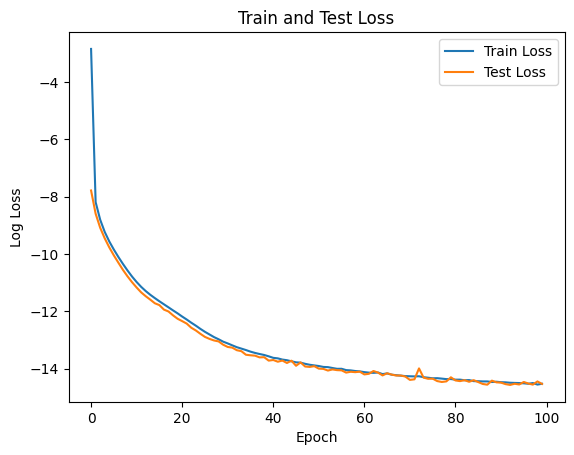

In [54]:
# Assuming train_data, train_labels, test_data, and test_labels are preprocessed and loaded

! rm -r checkpoints/

state = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, num_epochs, 
                           batch_size, learning_rate, os.path.abspath("checkpoints"))

Epoch 10, Train Loss: 0.0000867, Test Loss: 0.0000173
Epoch 20, Train Loss: 0.0000408, Test Loss: 0.0000057
Epoch 30, Train Loss: 0.0000102, Test Loss: 0.0000030
Epoch 40, Train Loss: 0.0000040, Test Loss: 0.0000020
Epoch 50, Train Loss: 0.0000024, Test Loss: 0.0000015
Epoch 60, Train Loss: 0.0000018, Test Loss: 0.0000013
Epoch 70, Train Loss: 0.0000015, Test Loss: 0.0000010
Epoch 80, Train Loss: 0.0000013, Test Loss: 0.0000010
Epoch 90, Train Loss: 0.0000011, Test Loss: 0.0000009
Epoch 100, Train Loss: 0.0000010, Test Loss: 0.0000008
Model saved to /home/durifa/Documents/deep_emulators/ige_deep_emulators/checkpoints_noise.


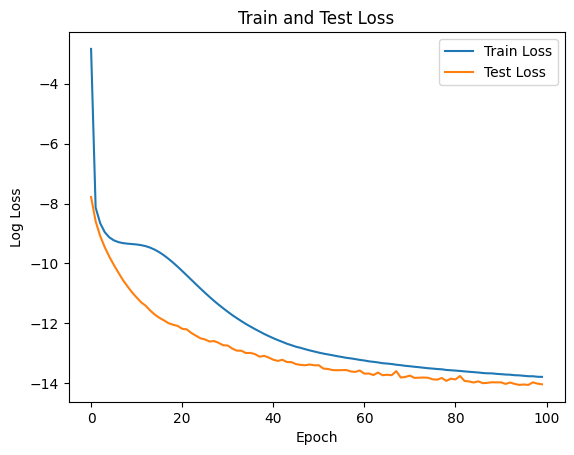

In [ ]:
! rm -r checkpoints_noise/

state_noise = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, num_epochs, 
                           batch_size, learning_rate, os.path.abspath("checkpoints_noise"), 
                           noise_augmentation=True, plot_str="noise")

Epoch 10, Train Loss: 0.0000564, Test Loss: 0.0000138
Epoch 20, Train Loss: 0.0000355, Test Loss: 0.0000052
Epoch 30, Train Loss: 0.0000305, Test Loss: 0.0000030
Epoch 40, Train Loss: 0.0000288, Test Loss: 0.0000024
Epoch 50, Train Loss: 0.0000281, Test Loss: 0.0000020
Epoch 60, Train Loss: 0.0000278, Test Loss: 0.0000017
Model saved to /home/durifa/Documents/deep_emulators/ige_deep_emulators/checkpoints_reg.


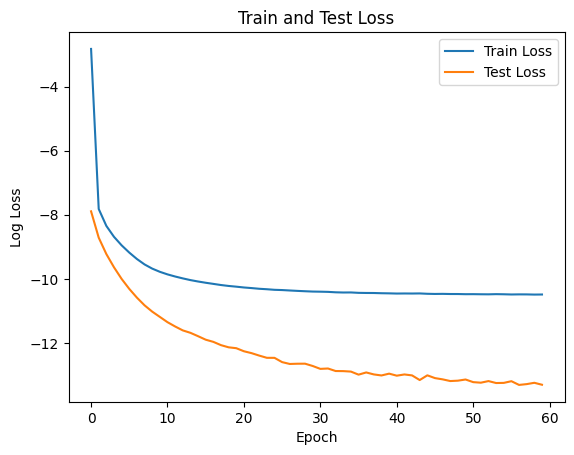

In [ ]:
# Test with regularizing loss

! rm -r checkpoints_reg/

state_reg = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, 60, 
                           batch_size, learning_rate, os.path.abspath("checkpoints_reg"),
                           reg=True, plot_str="reg")